# Project pipeline

This notebook contains the full pipeline from **data curation** to **transfer learning**. 

It has been optimized to work on a RTX3070 with **8GB VRAM**. 

Make sure to create a venv using the **requirements.txt**


## Contents

* **Dataset:**  
  Download the Animals-10 dataset from kaggle and save to data. 

* **Analysis:**  
  Initial analysis for necessary statistics for ResNet50 model training. 

* **Outlier detection:**  
  Create embedding vectors from images and use a combination of PCA and UMAP to display and detect outliers. 

* **Webdataset:**  
  Create a portable WebDataset including training and test shards. 

* **Hyperparameter tuning:**  
  Utilize ML Flow and Optuna to track, store and optimize a hyperparameter space. 

* **Final model:**  
  Trains a final model using the best hyperparameters and compare it to the test set. 

## Data Curation
Dataset, Analysis, Outlier detection, Webdataset

### Dataset

Dataset used is Animals-10 from Kaggle. 

It contains about 27k images obtained by webscraping Google image search for 10 different animals. 

In [1]:
# Download dataset from Kaggle
import kagglehub
from functions.data_curation import prepare_animal_dataset
path = kagglehub.dataset_download("alessiocorrado99/animals10")

# Prepare the dataset with translated class names
dataset_stats = prepare_animal_dataset(
    path, 
    destination_dir = './data/raw', 
    verbose = False
    )


Summary: 10 folders copied successfully
No errors occurred

Contents of destination directory:
  - butterfly: 2112 files
  - sheep: 1820 files
  - dog: 4863 files
  - cat: 1668 files
  - chicken: 3098 files
  - spider: 4821 files
  - squirrel: 1862 files
  - cow: 1866 files
  - elephant: 1446 files
  - horse: 2623 files


### Initial analysis and cleanup
Display relevant statistics and create a cleaned copy of the dataset.

Provides **dataset_analysis_report.txt** & **dataset_cleaning_report.txt** for reference.

## 📂 Dataset Folder Structure

```
DATASET_PATH: ./data/raw/
FOLDER_STRUCTURE:
  - sheep (1820 images)
  - butterfly (2112 images)
  - chicken (3098 images)
  - elephant (1446 images)
  - cat (1668 images)
  - horse (2623 images)
  - squirrel (1862 images)
  - cow (1866 images)
  - spider (4821 images)
  - dog (4863 images)

```

## 📊 Dataset Summary Statistics

## 🔍 Small Image Analysis

## 📁 Class Distribution

## 🖼️ Image Characteristics

## 📄 File Formats

## ❌ Corrupted Files

✅ No corrupted files found

## 📸 Sample Images

Report saved to dataset_analysis_report.txt


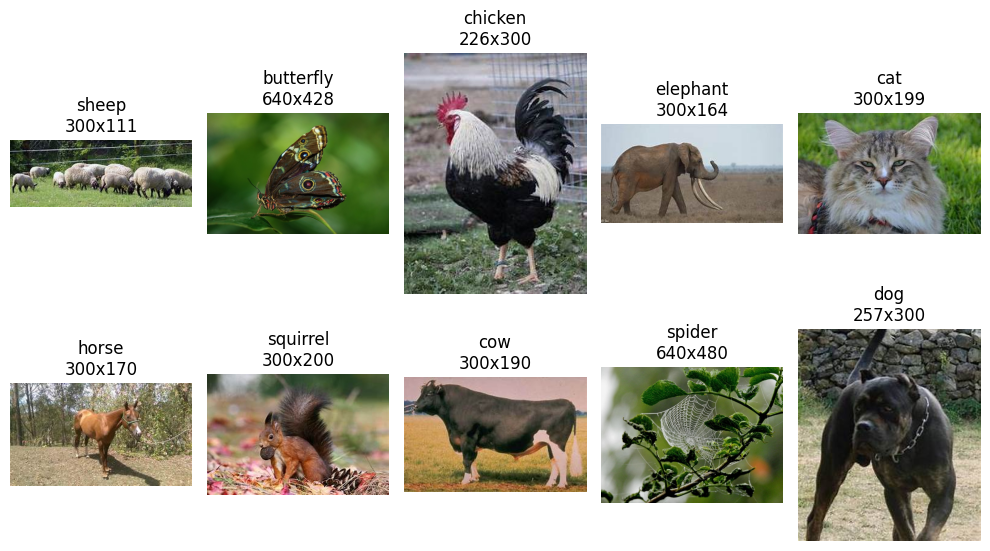

In [2]:
# Analysis and report
from functions.data_curation import analyze_dataset, display_dataset_report
analysis = analyze_dataset(dataset_path="./data/raw/")
display_dataset_report(analysis)

In [3]:
# Clean dataset
from functions.data_curation import clean_image_dataset
clean_stats = clean_image_dataset(
    src_path="./data/raw/",
    dest_path="./data/cleaned/",
    keep_grayscale=False,
    keep_rgba=False,
    keep_duplicates=False,
    min_resolution=128,
    use_analysis=analysis
)

=== Dataset Cleaning Complete ===

Source: ./data/raw/
Destination: ./data/cleaned/

Total files processed: 26179
Total files copied: 26003
Total files excluded: 176

Detailed report saved to dataset_cleaning_report.txt


### Outlier analysis

Utilize headless ResNet50 to create embedding vectors of each image. 

Applies a combination of PCA and UMAP to display dataset clusters as well as a configurable outlier map.

#### Config

In [4]:
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATA_PATH = "data/cleaned"
UMAP_PARAMS = {
    'n_components': 2,
    'target_metric': 'categorical',
    'target_weight': 0.5,
    'random_state': 42,
    'n_jobs': -1
}

#### Process data

##### Get pre-trained embeddings from resnet50

In [5]:
from functions.data_curation import (
    initialize_model, 
    process_image_directory, 
    create_embeddings
    )
model, transform = initialize_model(DEVICE)
features, labels, paths = process_image_directory(DATA_PATH, DEVICE, transform)
embedding, le, pca, reducer = create_embeddings(features, labels, umap_params=UMAP_PARAMS)

##### Outlier settings

Configurable settings.  
Apply and check samples.  
Make a decision on how much data you are willing to cut in order to skip manual inspection. 

In [6]:
from functions.data_curation import (
    detect_outliers, 
    create_results_dataframe
    )
# Detect outliers
class_outliers, global_outliers = detect_outliers(
    embedding, labels,
    class_n_neighbors=30,
    class_contamination=0.05,
    global_n_neighbors=75,
    global_contamination=0.05
)
df = create_results_dataframe(embedding, labels, paths, class_outliers, global_outliers)

#### Visualization

##### Plots

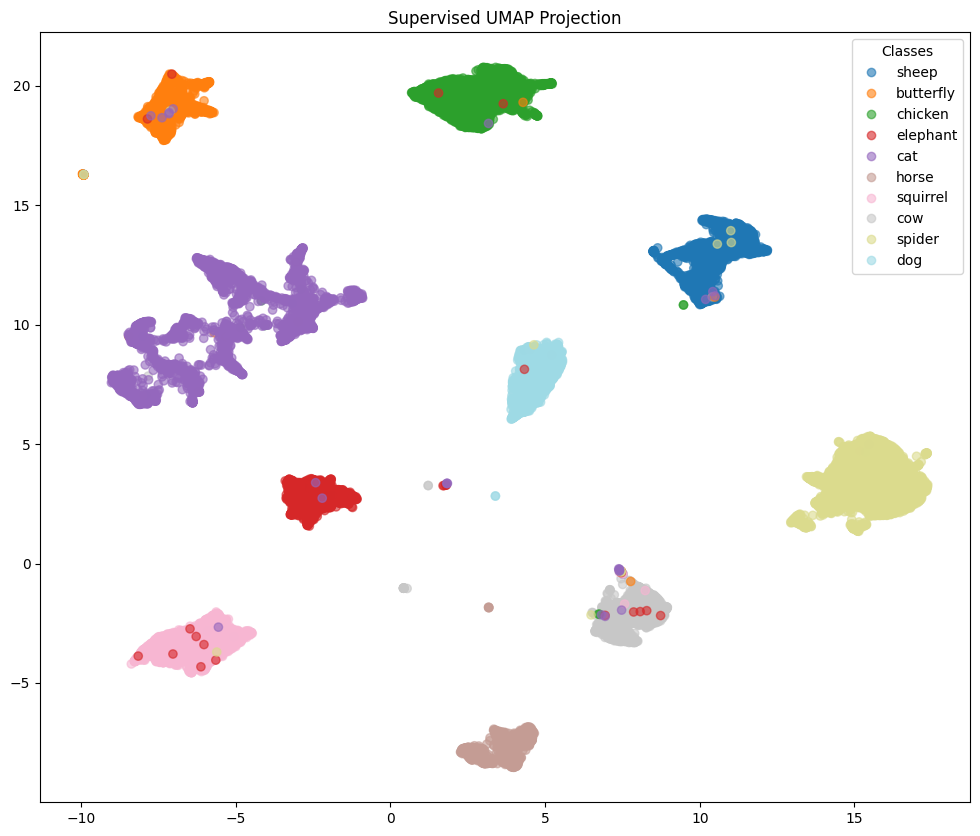

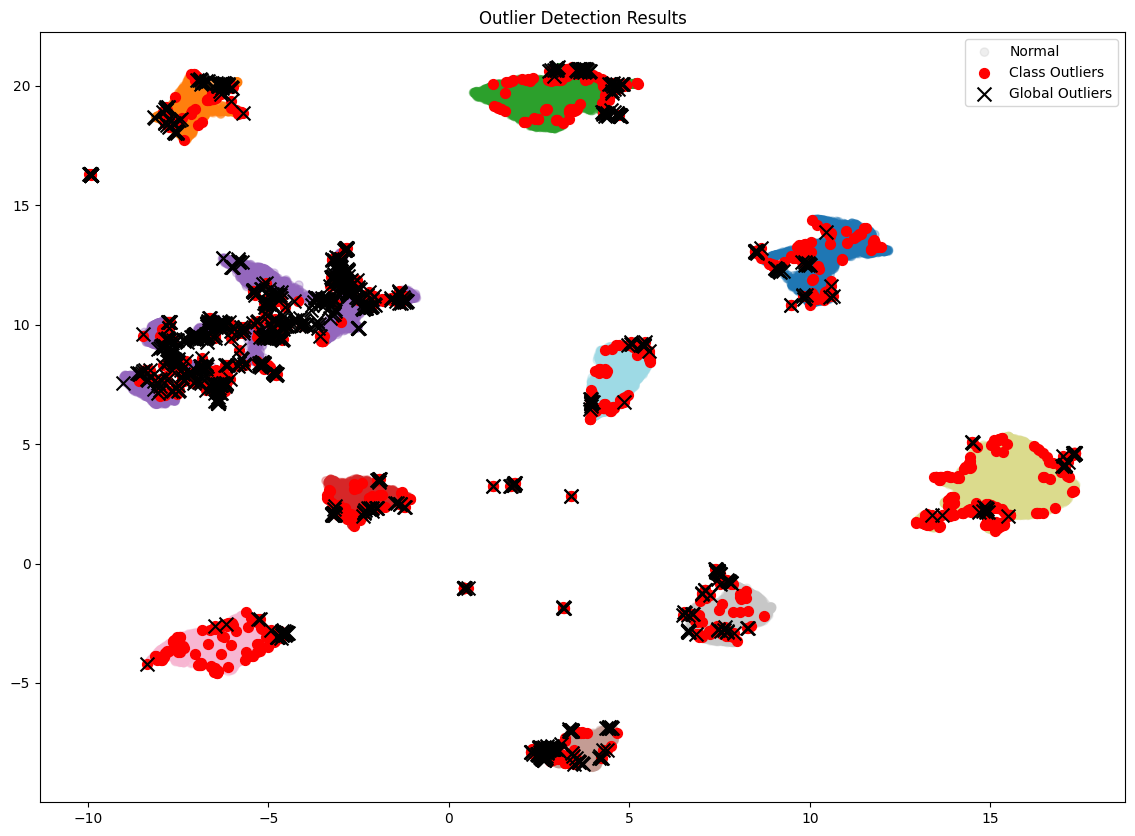

In [7]:
from functions.data_curation import (
    plot_umap, 
    plot_outliers
    )
plot_umap(df)
plot_outliers(df)

##### Statistics

In [8]:
from functions.data_curation import display_outlier_stats
# Display outlier statistics
display_outlier_stats(df)

##### Sample outliers

Change RANDOM_STATE to scroll through samples of detected outliers. 

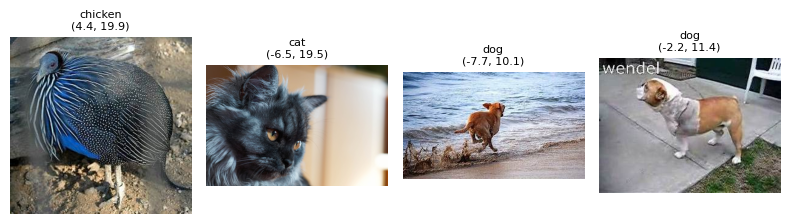

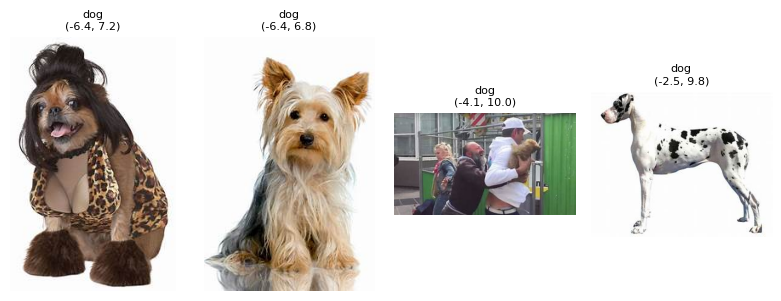

In [40]:
from functions.data_curation import display_outlier_samples
# Display outlier samples
RANDOM_STATE = 765765
N_SAMPLES = 4
FIGSIZE = (8, 3)
display_outlier_samples(df, outlier_type='class', random_state=RANDOM_STATE, n_samples=N_SAMPLES, figsize=FIGSIZE)
display_outlier_samples(df, outlier_type='global', random_state=RANDOM_STATE, n_samples=N_SAMPLES, figsize=FIGSIZE)

##### Save non-outliers in a seperate folder

In [41]:
from functions.data_curation import create_clean_dataset
clean_data_root = "data/no_outliers"  # Where to save cleaned dataset

# Run the cleaning process
create_clean_dataset(df, clean_data_root)

Copying clean images: 100%|██████████| 23864/23864 [00:03<00:00, 7299.28it/s]


Done! Clean dataset created at data/no_outliers
Original images: 26003
Clean images: 23864
Outliers removed: 2139

Class distribution in clean dataset:
butterfly: 1938 images
cat: 1485 images
chicken: 2862 images
cow: 1719 images
dog: 4126 images
elephant: 1262 images
horse: 2447 images
sheep: 1699 images
spider: 4565 images
squirrel: 1761 images


### Curated WebDataset

Use center crop.  
Resize to 224 by 224 pixels.  
Save as training & test shards.  
The test set will be balanced.

#### Process data

In [42]:
# Set random seed for reproducibility
import random
import numpy as np
random.seed(42)
np.random.seed(42)

In [43]:
from functions.data_curation import process_dataset
# Set paths
input_dir = "./data/no_outliers/"
output_dir = "./data/webdataset/"

# Process parameters
test_size = 0.2         # 20% of the smallest class for balanced testing
samples_per_shard = 1000  # Number of samples per WebDataset shard

# Execute processing
results = process_dataset(
    input_dir=input_dir,
    output_dir=output_dir,
    test_size=test_size,
    samples_per_shard=samples_per_shard
)

Found 10 classes with 23864 total images
Created balanced test set with 2520 images (252 per class)
Training set has 21344 images

Class distribution in train set:
butterfly: 1686
cat: 1233
chicken: 2610
cow: 1467
dog: 3874
elephant: 1010
horse: 2195
sheep: 1447
spider: 4313
squirrel: 1509

Class distribution in test set:
butterfly: 252
cat: 252
chicken: 252
cow: 252
dog: 252
elephant: 252
horse: 252
sheep: 252
spider: 252
squirrel: 252
Writing 21344 samples to 21 shards at ./data/webdataset/train-%06d.tar


Creating train dataset: 100%|████████████| 21344/21344 [00:44<00:00, 482.79it/s]


Finished writing train dataset
Writing 2520 samples to 2 shards at ./data/webdataset/test-%06d.tar


Creating test dataset: 100%|███████████████| 2520/2520 [00:05<00:00, 469.85it/s]

Finished writing test dataset


#### Verification

Checking path: ./data/webdataset/
Directory exists. Files in directory:
  train-000000.tar
  train-000001.tar
  train-000002.tar
  train-000003.tar
  train-000004.tar
  train-000005.tar
  train-000006.tar
  train-000007.tar
  train-000008.tar
  train-000009.tar
  train-000010.tar
  train-000011.tar
  train-000012.tar
  train-000013.tar
  train-000014.tar
  train-000015.tar
  train-000016.tar
  train-000017.tar
  train-000018.tar
  train-000019.tar
  train-000020.tar
  train-000021.tar
Using the first WebDataset file: ./data/webdataset/train-000000.tar
Verifying WebDataset at ./data/webdataset/train-000000.tar...


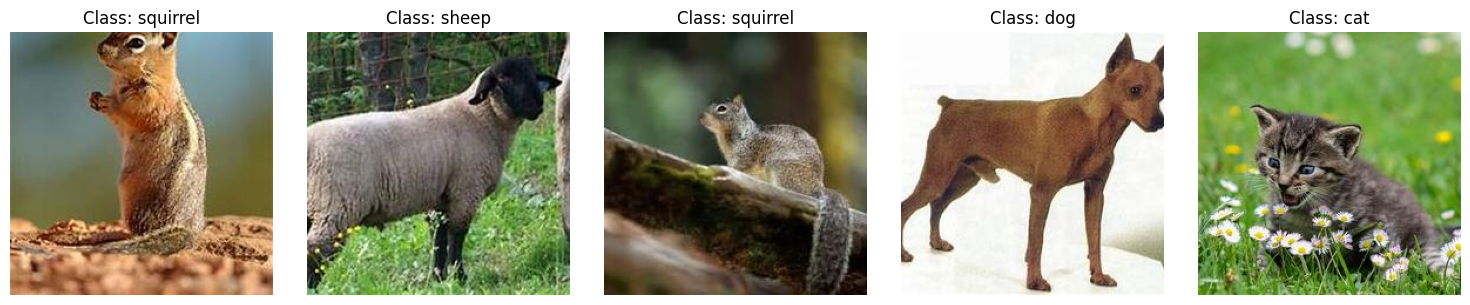

WebDataset verification successful!


In [ ]:
import os
from functions.data_curation import verify_webdataset
output_dir = "./data/webdataset/"

# Verify the training dataset
# Make sure the path exists
print(f"Checking path: {output_dir}")
if os.path.exists(output_dir):
    print(f"Directory exists. Files in directory:")
    train_files = []
    for f in sorted(os.listdir(output_dir)):
        if f.startswith('train-'):
            train_files.append(f)
            print(f"  {f}")
    
    if not train_files:
        print("No training files found!")
    else:
        # Use just the first file for testing to simplify
        train_path = os.path.join(output_dir, train_files[0])
        print(f"Using the first WebDataset file: {train_path}")
        verify_webdataset(train_path)
else:
    print(f"Directory does not exist!")

## Hyperparameter tuning

Aggressive pruning by first fold minimum threshold as well as optunas median pruning strategy by running validation accuracy average after each fold. 

Metric used in optuna optimization is the lower bound of the average validation accuracy from the collective best epoch of all folds measured with the t-distribution at 80% confidence. 

Each trial is stored using ML Flow and can be viewed by typing mlflow ui in the terminal. 

Hyperparameter study from optuna uses SQLite and stored in the root project folder using db_path variable.  
Cells provide information about statistics but optuna dashboard can be used as well. 

### Setup

In [1]:
# Config setup
import config
from functions.utility import analyze_webdataset
import mlflow
import torch
import glob
import os

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

config.DEVICE = device

# Configure MLflow
mlflow.set_experiment("animals10")

# Define constants
DATA_DIR = "./data/webdataset/"

# Relative file paths
config.TRAIN_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, "train-*.tar")))
config.TEST_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, "test-*.tar")))

print(f"Found {len(config.TRAIN_PATHS)} training files and {len(config.TEST_PATHS)} test files")

num_classes, class_names, class_weights = analyze_webdataset(DATA_DIR, verbose=False)
print(f"\nTraining data summary:")
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")
print(f"Class weights tensor shape: {class_weights.shape}")

# Update the config module variables
config.NUM_CLASSES = num_classes
config.CLASS_NAMES = class_names
config.CLASS_WEIGHTS = class_weights

Using device: cuda:0
Found 22 training files and 3 test files

Training data summary:
Number of classes: 10
Class names: ['spider', 'dog', 'chicken', 'horse', 'butterfly', 'squirrel', 'cow', 'sheep', 'cat', 'elephant']
Class weights tensor shape: torch.Size([10])


### Hyperparameter search
**RECOMMENDATION:**  
It is recommended to use python run_hyperopt.py from terminal for performance. 

In [ ]:
# Run the k-fold cross validation optimization
from functions.hyperopt import run_kfold_optuna_optimization
db_path = "optuna_animals10_kfold.db"
k_fold_study = run_kfold_optuna_optimization(
    n_trials=1,      # Number of trials
    k=3,             # Number of folds
    verbose=True,   # Reduce output
    study_name="animals10_kfold",  # Name of the study
    storage=db_path, # Store results in SQLite
    load_if_exists=True,
    first_fold_min_acc=90.0,  # Minimum accuracy for the first fold
    notebook=True,  # Set to True if running in a Jupyter notebook
)

### Optuna study
Run the native optuna-dashboard from terminal or get an overview from the following cells

In [2]:
# Load the study from the SQLite database
import optuna
db_path = "optuna_animals10_kfold.db"
study_name="animals10_kfold"
storage_string = f"sqlite:///{db_path}"
k_fold_study = optuna.load_study(
                study_name=study_name,
                storage=storage_string
            )
print("Run the following command to visualize the results:")
print(f"optuna-dashboard {storage_string}")

Run the following command to visualize the results:
optuna-dashboard sqlite:///optuna_animals10_kfold.db


#### Best trial

Best Trial: #22
Value: 97.76749428076316

Parameters:
  learning_rate: 0.00015355230600334768
  batch_size: 8
  weight_decay: 2.112612834705556e-06
  dropout_rate: 0.1353879559974798
  augmentation_intensity: medium
  patience: 4
  max_epochs: 10

MLflow Run ID: 9d22fc57035249fe83c6c2f2d19d5c83


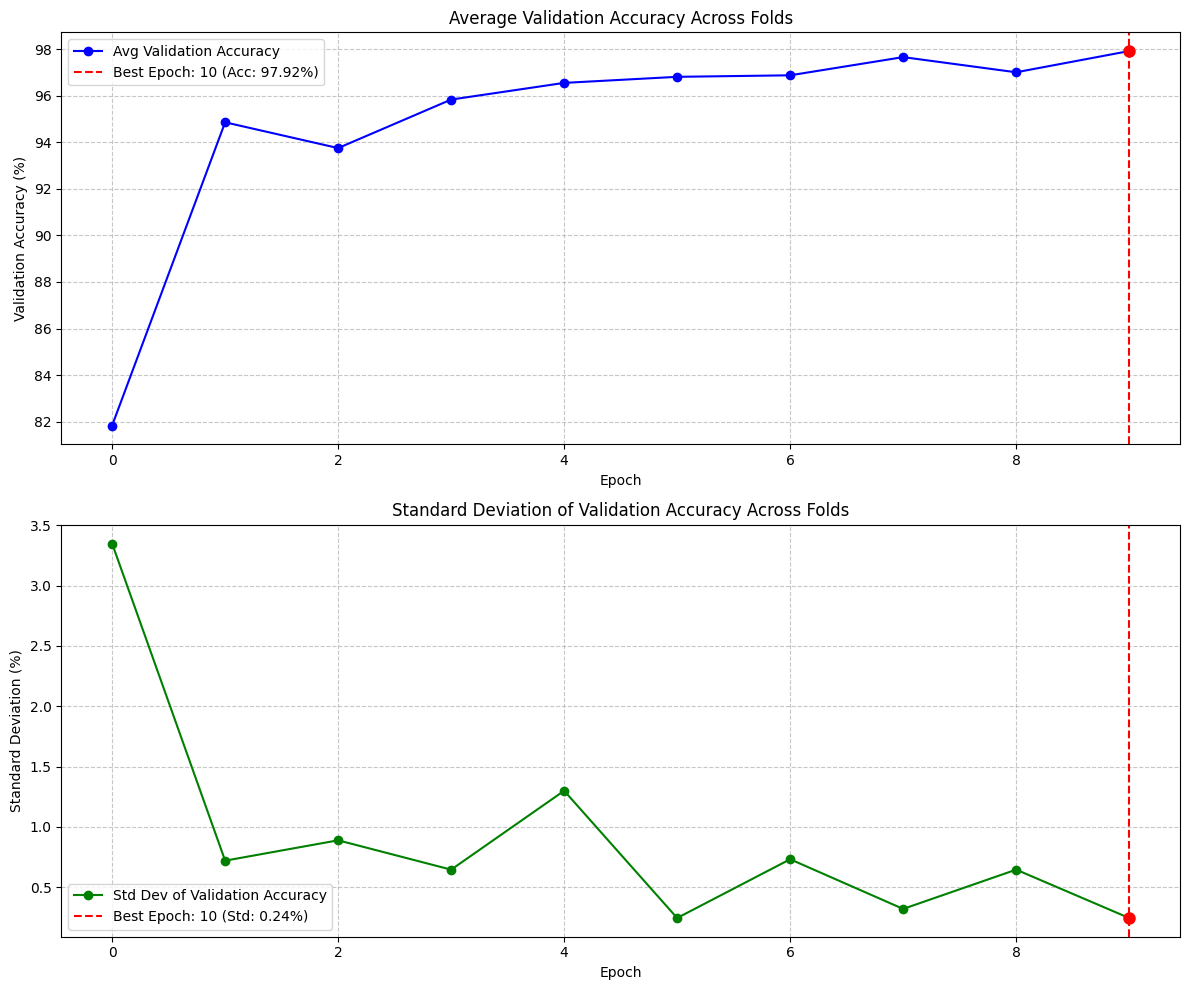


Best epoch metrics (Epoch 10):
  Average validation accuracy: 97.92%
  Standard deviation: 0.24%
  80% confidence interval: [97.77%, 98.07%]
  Lower bound (study objective): 97.77%


In [3]:
# To visualize metrics for the best trial:
from functions.hyperopt import visualize_best_trial_metrics
visualize_best_trial_metrics(k_fold_study)

#### Study overview

Study: animals10_kfold
Total trials: 25
Completed trials: 18 (72.0%)
Pruned trials: 6 (28.0%)


number      value             datetime_start          datetime_complete  \
22      22  97.767494 2025-05-05 17:45:48.367567 2025-05-05 17:47:58.666005   
16      16  97.518066 2025-05-05 17:34:14.025332 2025-05-05 17:36:24.316609   
2        2  97.413278 2025-05-05 17:00:49.587093 2025-05-05 17:03:30.007694   
0        0  97.246661 2025-05-05 16:57:55.039247 2025-05-05 17:00:03.700855   
4        4  97.181557 2025-05-05 17:04:31.326651 2025-05-05 17:07:24.810284   

                 duration params_augmentation_intensity  params_batch_size  \
22 0 days 00:02:10.298438                        medium                  8   
16 0 days 00:02:10.291277                        medium                  8   
2  0 days 00:02:40.420601                          high                 32   
0  0 days 00:02:08.661608                        medium                  8   
4  0 days 00:02:53.483633                           low                  8   

    params_dropout_rate  params_learning_rate  params_max_epochs  \
22             0.135388              0.000154                 10   
16             0.329514              0.000084                 11   
2              0.257117              0.000075                 10   
0              0.077997              0.000133                 10   
4              0.092427              0.000060                 16   

    params_patience  params_weight_decay          user_attrs_mlflow_run_id  \
22                4             0.000002  9d22fc57035249fe83c6c2f2d19d5c83   
16                3             0.000004  957827d6aa32480ca7d9d16cbb216b3d   
2                 3             0.000004  61f8755d585442cbb072fbc3f3f05e61   
0                 5             0.000003  8d0efcd4fa9d45569e32a1b9f2f11939   
4                 6             0.000044  71587ae6e9d5430db83b37d8567bf469   

       state  
22  COMPLETE  
16  COMPLETE  
2   COMPLETE  
0   COMPLETE  
4   COMPLETE


Performance statistics (objective value):
  Best: 97.77
  Median: 96.81
  Mean: 96.53 ± 0.91
  Worst completed: 94.74

Best trial:
  Trial 22: 97.77
     learning_rate: 0.00015355230600334768
     batch_size: 8
     weight_decay: 2.112612834705556e-06
     dropout_rate: 0.1353879559974798
     augmentation_intensity: medium
     patience: 4
     max_epochs: 10


Parameter importance analysis:
  learning_rate: 0.2881
  batch_size: 0.2447
  dropout_rate: 0.2242
  weight_decay: 0.1182
  augmentation_intensity: 0.0666
  max_epochs: 0.0333
  patience: 0.0250

Parameter distributions in successful trials:
  learning_rate:
    Range: 1.667761543019792e-05 to 0.0011389740369231404
    Mean: 0.0002275 ± 0.0003006
    Best trial: 0.00015355230600334768
  batch_size:
    Range: 8 to 32
    Mean: 18.22 ± 11.25
    Best trial: 8
  weight_decay:
    Range: 1.0557544328333267e-06 to 0.0008102356207766632
    Mean: 6.858e-05 ± 0.0001862
    Best trial: 2.112612834705556e-06
  dropout_rate:
    Range:

/home/eaglewing/repo/ml/image-recognition-pipeline/functions/hyperopt.py:726: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Figure size 1200x600 with 0 Axes>

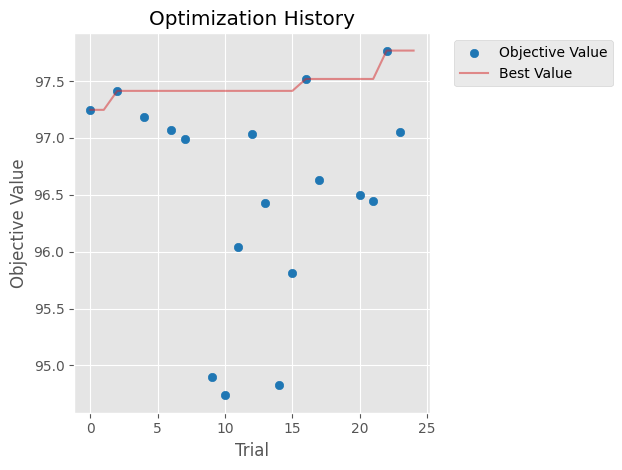

/home/eaglewing/repo/ml/image-recognition-pipeline/functions/hyperopt.py:734: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Figure size 1200x600 with 0 Axes>

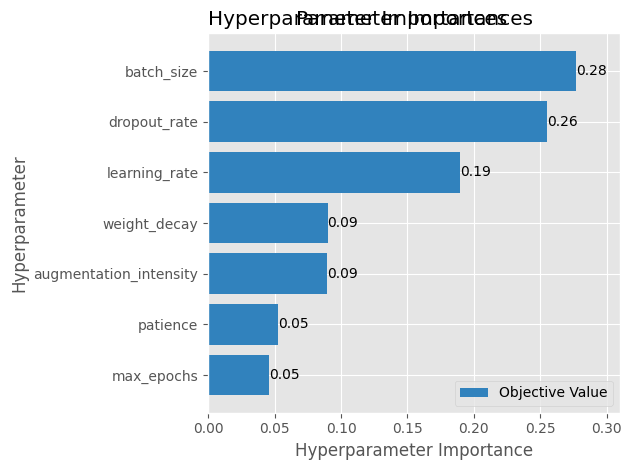

/home/eaglewing/repo/ml/image-recognition-pipeline/functions/hyperopt.py:744: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study)


<Figure size 1400x700 with 0 Axes>

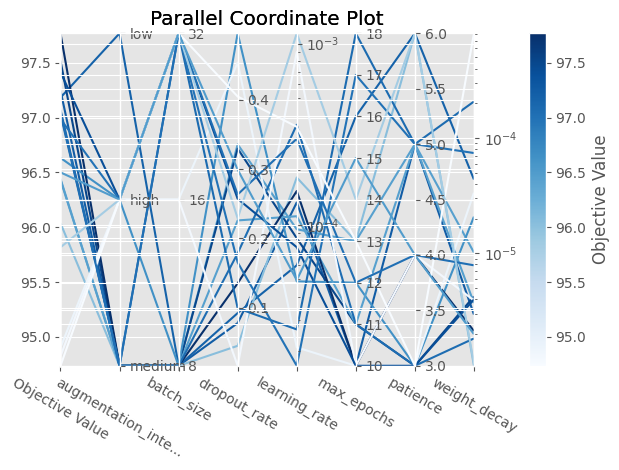

{'study_name': 'animals10_kfold',
 'total_trials': 25,
 'completed_trials': 18,
 'pruned_trials': 6,
 'completion_rate': 0.72,
 'best_value': 97.76749428076316,
 'worst_value': 94.7362456245374,
 'median_value': np.float64(96.80913611148937),
 'mean_value': np.float64(96.53266296291882),
 'std_value': np.float64(0.9069588170714203)}

In [4]:
# To get detailed analysis of your hyperparameter optimization:
from functions.hyperopt import enhanced_optuna_analysis
enhanced_optuna_analysis(k_fold_study)

## Final model

3 fold cross validation was used. 
25 trials 

### Training

In [5]:
# Train the final model after hyperparameter optimization
from functions.final import train_final_model
final_model, final_test_acc = train_final_model(k_fold_study)
print(f"Final model test accuracy: {final_test_acc:.2f}%")

Training final model with best hyperparameters:
  learning_rate: 0.00015355230600334768
  batch_size: 8
  weight_decay: 2.112612834705556e-06
  dropout_rate: 0.1353879559974798
  augmentation_intensity: medium
  patience: 4
  max_epochs: 10
Using recommended_epochs from k-fold CV: 10
Using all 22 training shards
Created temporary directory for artifacts: /tmp/tmppmvr419m

Epoch 1/10
--------------------


Training: 0it [00:00, ?it/s]

Train Loss: 0.9325, Train Acc: 81.83%
GPU memory: Allocated: 0.29 GB, Reserved: 0.40 GB

Epoch 2/10
--------------------


Training: 0it [00:00, ?it/s]

Train Loss: 0.2844, Train Acc: 92.10%
GPU memory: Allocated: 0.29 GB, Reserved: 0.40 GB

Epoch 3/10
--------------------


Training: 0it [00:00, ?it/s]

Train Loss: 0.2100, Train Acc: 94.19%
GPU memory: Allocated: 0.29 GB, Reserved: 0.40 GB

Epoch 4/10
--------------------


Training: 0it [00:00, ?it/s]

Train Loss: 0.1671, Train Acc: 95.25%
GPU memory: Allocated: 0.29 GB, Reserved: 0.40 GB

Epoch 5/10
--------------------


Training: 0it [00:00, ?it/s]

Train Loss: 0.1392, Train Acc: 95.92%
GPU memory: Allocated: 0.29 GB, Reserved: 0.40 GB

Epoch 6/10
--------------------


Training: 0it [00:00, ?it/s]

Train Loss: 0.1183, Train Acc: 96.44%
GPU memory: Allocated: 0.29 GB, Reserved: 0.40 GB

Epoch 7/10
--------------------


Training: 0it [00:00, ?it/s]

Train Loss: 0.1014, Train Acc: 97.02%
GPU memory: Allocated: 0.29 GB, Reserved: 0.40 GB

Epoch 8/10
--------------------


Training: 0it [00:00, ?it/s]

Train Loss: 0.0863, Train Acc: 97.54%
GPU memory: Allocated: 0.29 GB, Reserved: 0.40 GB

Epoch 9/10
--------------------


Training: 0it [00:00, ?it/s]

Train Loss: 0.0786, Train Acc: 97.73%
GPU memory: Allocated: 0.29 GB, Reserved: 0.40 GB

Epoch 10/10
--------------------


Training: 0it [00:00, ?it/s]

Train Loss: 0.0722, Train Acc: 97.82%
GPU memory: Allocated: 0.29 GB, Reserved: 0.40 GB


2025/05/05 20:55:56 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/05 20:56:03 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.22.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.22.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/05 20:56:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Evaluating final model on test set...
Evaluating model on full test set (no batch limit)...


Full Evaluation: 0it [00:00, ?it/s]

Evaluated on 2520 samples: Loss=0.0674, Accuracy=98.45%

Final Test Results:
  Loss: 0.0674
  Accuracy: 98.45%

Generating classification visualizations...


Finding samples: 0it [00:00, ?it/s]

Visualization images saved to /tmp/tmppmvr419m/correct_classifications.png and /tmp/tmppmvr419m/incorrect_classifications.png
Cleaned up temporary artifact directory: /tmp/tmppmvr419m
Final model test accuracy: 98.45%


### Visualization

Using final model run c18626c465544b85a5d4c0a5857ed19e with test accuracy: 98.45%
Searching for visualization artifacts in run: c18626c465544b85a5d4c0a5857ed19e

## Confusion Matrix


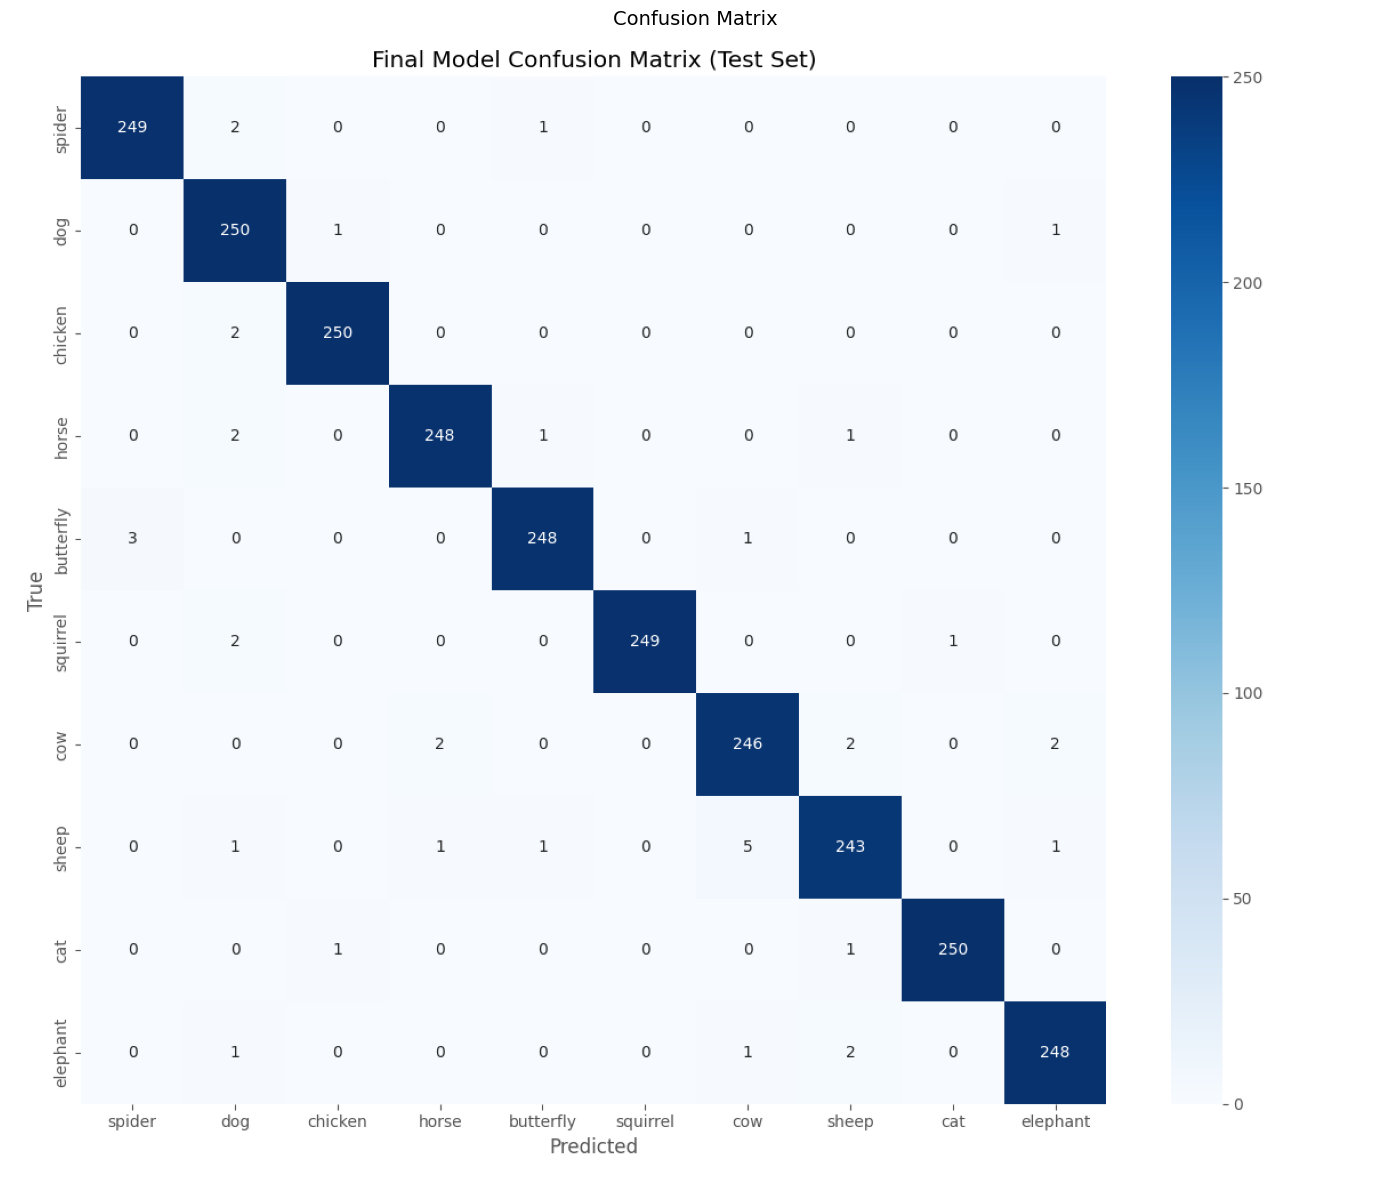


## Correct Classifications


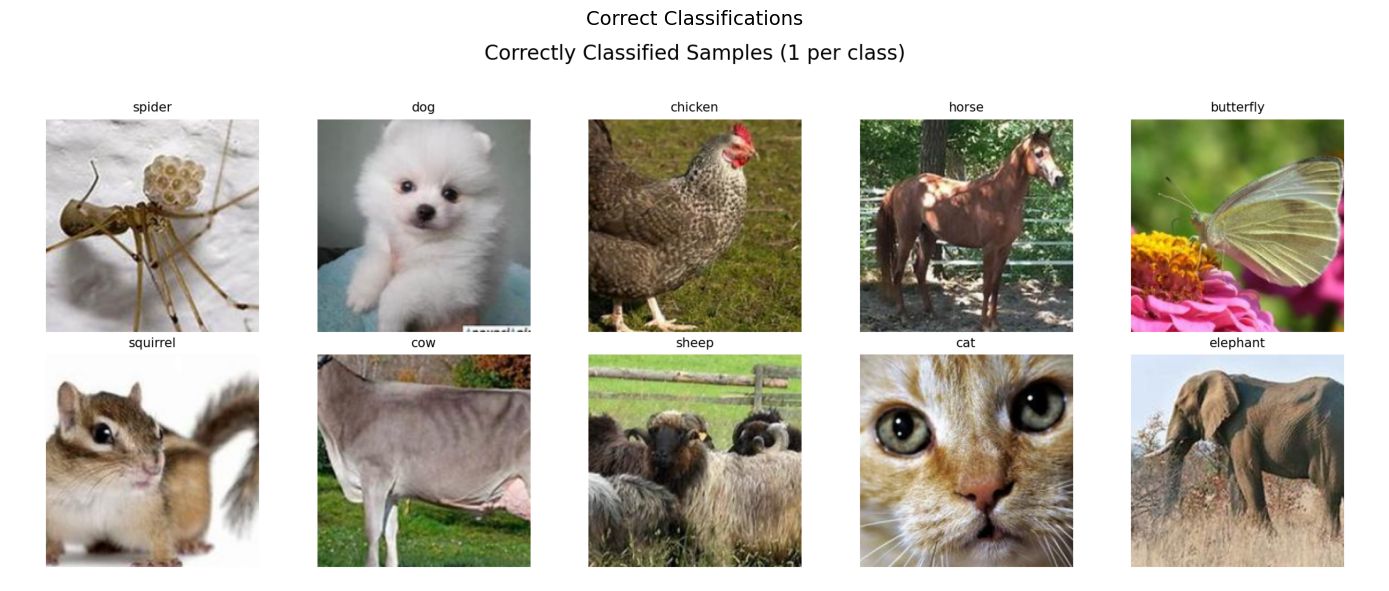


## Incorrect Classifications


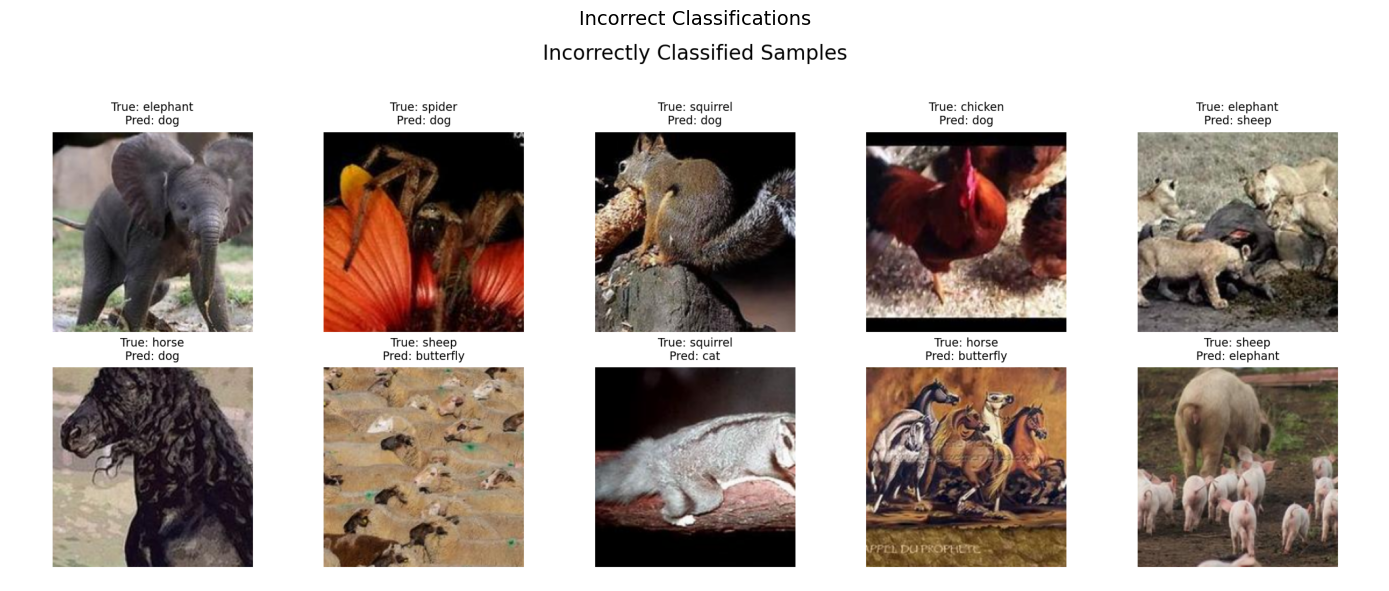

In [6]:
# Display visualizations from the best run
from functions.final import display_model_visualizations
artifacts = display_model_visualizations()